In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

data= pd.read_csv("/content/drive/MyDrive/Cyberbullying_Kaggle_Data/cyberbullying_tweets.csv")

In [44]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


**Phase 1: EDA to see distribution of** **Tweets**

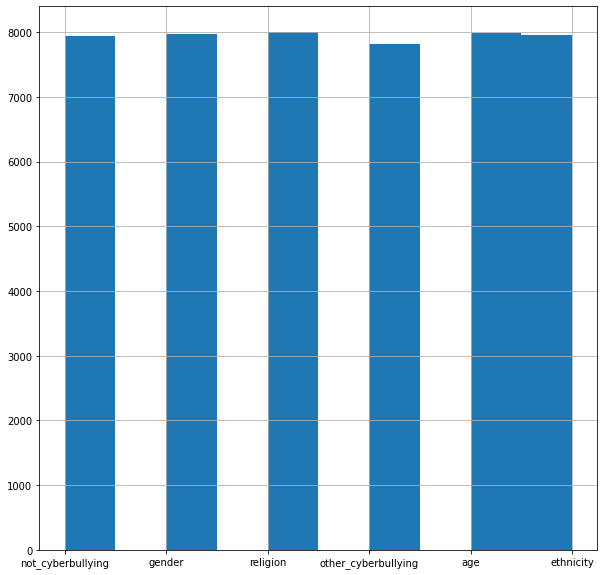

In [45]:
#Distribution of tweets
data.cyberbullying_type.hist() #Histogram shows that the dataset is balanced and has equal representation for all labels

**Word Cloud of tweets for EDA**

In [46]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [47]:
text = " ".join(review for review in data.tweet_text)

# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update([])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

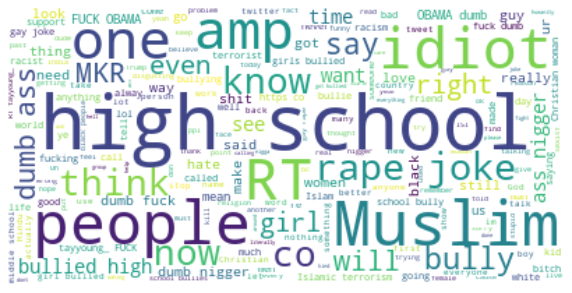

In [48]:
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

**Phase 2: Building a base model for multi-class classification**

**TEXT PREPROCESSING** functions defintion:

In [49]:
# import TweetTokenizer() method from nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Create a reference variable for Class WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Create a reference variable for Class TweetTokenizer
tk = TweetTokenizer()

#Preprocessing: Tweet Tokenizer + lowercase conversion
def LC_tokeniser(df):
  df["tokens"]= df["tweet_text"].apply(lambda x: tk.tokenize(x.lower()))
  return df
#Recover Hashtags
def hashtag(df):
  df["hastags"]= df["tokens"].apply(lambda x: [item for item in x if item.startswith("#")])
  return df
#Recover Mentions @
def mentions(df):
  df["mentions"]= df["tokens"].apply(lambda x: [item for item in x if item.startswith("@")])
  return df
#number of words in a tweet
def length(df):
  df["length"]= df["tokens"].apply(lambda x: len(x))
  return df

#Remove Stop-words
def remove_stopwords(df):
  df['remove_stopwords'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop_words])
  return df

#Lemmatisation to get root words and remove numbers if any!
def lemmatise(df):
  df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x if y.isalpha()]) 
  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [51]:
from sklearn.model_selection import train_test_split
df= LC_tokeniser(data)
df= hashtag(df)
df= mentions(df)
df= length(df)
df= remove_stopwords(df)
df= lemmatise(df)
df["hashtags_present"]=df["hastags"].apply(lambda x: int((len(x)>0)))
df["mentions_present"]= df["mentions"].apply(lambda x:int((len(x)>0)))
df.head()

,tweet_text,cyberbullying_type,tokens,hastags,mentions,length,remove_stopwords,lemmatise,hashtags_present,mentions_present
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",[],11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",1,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",[],15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],1,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],[@xochitlsuckkks],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0,1
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],[@jason_gio],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0,1
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],[@rudhoeenglish],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0,1


**Words associated with different types of cyber-bullying:**

In [52]:
df["lemma_sentence"]= df["lemmatise"].apply(lambda x: " ".join(str(w) for w in x))
religion= df[df.cyberbullying_type=="religion"]["lemma_sentence"]
religion.head()

15918    sudeep invite though right getting worded okay...
15919    islam never resistance oppression always sourc...
15920    boy comment journalist wanting keep church clo...
15921    hindu getting killed muslim terriorists kashmi...
15922    white supremicists many know idiot race coming...
Name: lemma_sentence, dtype: object

**Bullying Related to Religion**

In [53]:
text_religion = " ".join(lists for lists in religion)
stop_words = set(stopwords.words("english"))
# Generate a word cloud image
religion_wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text_religion)

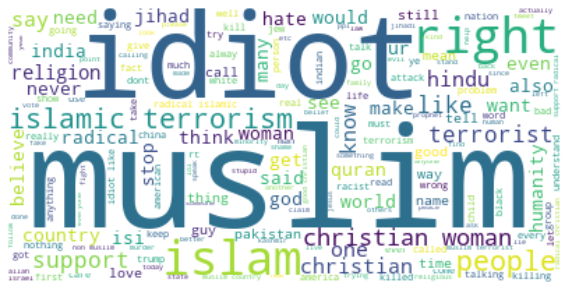

In [54]:
# Display the generated image:
# the matplotlib way:
plt.imshow(religion_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

***Bullying related to AGE***

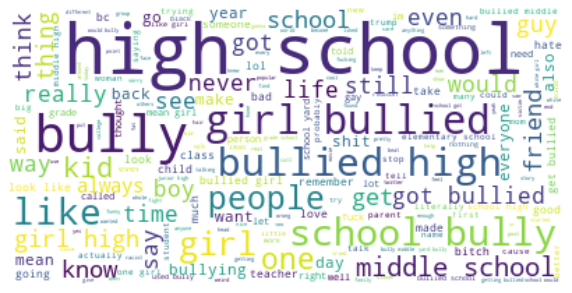

In [55]:
age= df[df.cyberbullying_type=="age"]["lemma_sentence"]
age.head()
text_age = " ".join(lists for lists in age)
stop_words = set(stopwords.words("english"))
# Generate a word cloud image
age_wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text_age)
# Display the generated image:
# the matplotlib way:
plt.imshow(age_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

***Bullying related to GENDER***

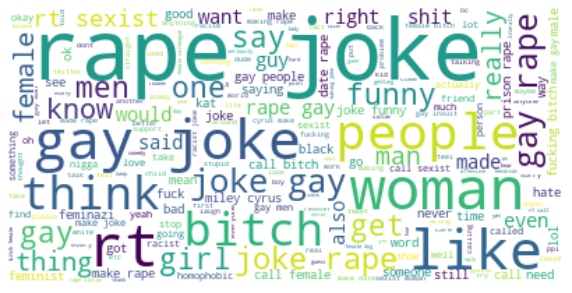

In [56]:
gender= df[df.cyberbullying_type=="gender"]["lemma_sentence"]
gender.head()
text_gender = " ".join(lists for lists in gender)
stop_words = set(stopwords.words("english"))
# Generate a word cloud imgender
gender_wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text_gender)
# Display the generated imgender:
# the matplotlib way:
plt.imshow(gender_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


***Bullying related to ethnicity***

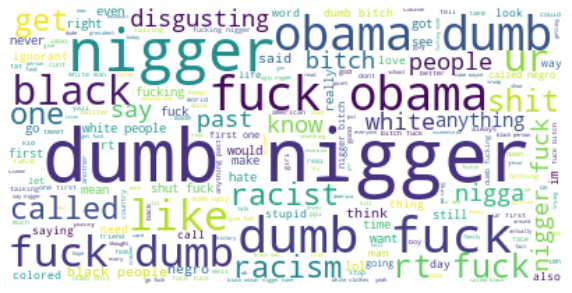

In [57]:
ethnicity= df[df.cyberbullying_type=="ethnicity"]["lemma_sentence"]
ethnicity.head()
text_ethnicity = " ".join(lists for lists in ethnicity)
stop_words = set(stopwords.words("english"))
# Generate a word cloud imethnicity
ethnicity_wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text_ethnicity)
# Display the generated imethnicity:
# the matplotlib way:
plt.imshow(ethnicity_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


***Bullying related to Other_cyberbullying types:***

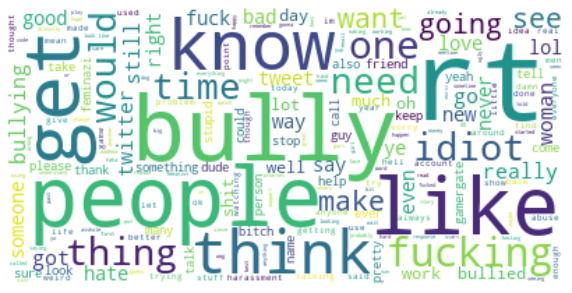

In [58]:
other_cyberbullying= df[df.cyberbullying_type=="other_cyberbullying"]["lemma_sentence"]
other_cyberbullying.head()
text_other_cyberbullying = " ".join(lists for lists in other_cyberbullying)
stop_words = set(stopwords.words("english"))
# Generate a word cloud imother_cyberbullying
other_cyberbullying_wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text_other_cyberbullying)
# Display the generated imother_cyberbullying:
# the matplotlib way:
plt.imshow(other_cyberbullying_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()
